In [1]:
import pandas as pd
import os.path as op
import retro
from src.features.annotations import generate_key_events, generate_aps_events, plot_bidsevents
from src.features.features import compute_framewise_aps
import matplotlib.pyplot as plt
from src.params import figures_path
from nilearn import plotting
from nilearn import image
import os
import numpy as np
from nilearn.plotting import plot_design_matrix


def retrieve_variables(files):
    '''
    files : list of files with complete path

    variable_lists : dictionnary (each variable is an entry) containing list of arrays of
    length corresponding to the number of frames in each run,
    with runs ordered by timestamp.
    '''

    variables_lists = {}

    for file in files:
        level = file[-11:-8]
        timestamp = file[-73:-65]
        print(file)
        if level == '5-0':
            env = retro.make('ShinobiIIIReturnOfTheNinjaMaster-Genesis', state='Level5')
        else:
            env = retro.make('ShinobiIIIReturnOfTheNinjaMaster-Genesis', state='Level'+level)
        actions = env.buttons

        run_variables = {}
        key_log = retro.Movie(file)
        env.reset()
        run_completed = False
        while key_log.step():
            a = [key_log.get_key(i, 0) for i in range(env.num_buttons)]
            _,_,done,i = env.step(a)

            if variables_lists == {}: # init final dict
                variables_lists['filename'] = []
                variables_lists['timestamp'] = []
                variables_lists['level'] = []
                for action in actions:
                    variables_lists[action] = []
                for variable in i.keys():
                    variables_lists[variable] = []

            if run_variables == {}: # init temp dict
                for variable in i.keys():
                    run_variables[variable] = []
                for action in actions:
                    run_variables[action] = []

            for variable in i.keys(): # fill up temp dict
                run_variables[variable].append(i[variable])
            for idx_a, action in enumerate(actions):
                run_variables[action].append(a[idx_a])

            if done == True:
                run_completed = True
        variables_lists['filename'].append(file)
        variables_lists['timestamp'].append(timestamp)
        variables_lists['level'].append(level)

        for variable in run_variables.keys():
            variables_lists[variable].append(run_variables[variable])
        env.close()
    return variables_lists

def create_runevents(runvars, startevents, actions, FS=60, min_dur=1, get_aps=True, get_actions=True):
    onset_reps = startevents['onset'].values.tolist()
    dur_reps = startevents['duration'].values.tolist()
    lvl_reps = [x[-11] for x in startevents['stim_file'].values.tolist()]
    
    if get_aps:
        framewise_aps = compute_framewise_aps(runvars, actions=actions, FS=FS)

    # init df list
    all_df = []

    for idx, onset_rep in enumerate(onset_reps):
        print('Extracting events for {}'.format(runvars['filename'][idx]))
        if get_actions:
            # get the different possible actions
            # generate events for each of them
            for act in actions:
                var = runvars[act][idx]
                temp_df = generate_key_events(var, act, FS=FS)
                temp_df['onset'] = temp_df['onset'] + onset_rep
                temp_df['trial_type'] = lvl_reps[idx] + '_' + temp_df['trial_type']
                all_df.append(temp_df)
        if get_aps:
            temp_df = generate_aps_events(framewise_aps[idx], FS=FS)
            temp_df['onset'] = temp_df['onset'] + onset_rep
            temp_df['trial_type'] = lvl_reps[idx] + '_' + temp_df['trial_type']
            all_df.append(temp_df)


    events_df = pd.concat(all_df).sort_values(by='onset').reset_index(drop=True)
    return events_df


In [ ]:
# Set constants
sub = 'sub-01'
ses = 'ses-008'
run = 'run-01'

actions = ['B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z']

dpath = '/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/'
events_fname = dpath + '{}/{}/func/{}_{}_task-shinobi_{}_events.tsv'.format(sub, ses, sub, ses, run)

In [ ]:
# Obtain list of bk2 files from events
startevents = pd.read_table(events_fname)
files = startevents['stim_file'].values.tolist()
files = [dpath + file for file in files]

# Retrieve variables from these files
runvars = retrieve_variables(files)
events_df = create_runevents(runvars, startevents, actions=actions)
events_df['trial_type'].unique()

In [ ]:
# Create APS_df 
lAPS_df = pd.concat([events_df[events_df['trial_type'] == '1_low_APS'],
                    events_df[events_df['trial_type'] == '4_low_APS'],
                    events_df[events_df['trial_type'] == '5_low_APS']
                   ]).sort_values(by='onset').reset_index(drop=True)
lAPS_df['trial_type'] = 'Low APS'

hAPS_df = pd.concat([events_df[events_df['trial_type'] == '1_high_APS'],
                    events_df[events_df['trial_type'] == '4_high_APS'],
                    events_df[events_df['trial_type'] == '5_high_APS']
                   ]).sort_values(by='onset').reset_index(drop=True)
hAPS_df['trial_type'] = 'High APS'


APS_df = pd.concat([hAPS_df, lAPS_df]).sort_values(by='onset').reset_index(drop=True)

In [ ]:
# Create LvR_df
lh_df = pd.concat([events_df[events_df['trial_type'] == '1_LEFT'], 
                   events_df[events_df['trial_type'] == '1_RIGHT'],
                   events_df[events_df['trial_type'] == '1_DOWN'],
                   events_df[events_df['trial_type'] == '1_UP'],
                   events_df[events_df['trial_type'] == '4_LEFT'], 
                   events_df[events_df['trial_type'] == '4_RIGHT'],
                   events_df[events_df['trial_type'] == '4_DOWN'],
                   events_df[events_df['trial_type'] == '4_UP'],
                    events_df[events_df['trial_type'] == '5_LEFT'], 
                   events_df[events_df['trial_type'] == '5_RIGHT'],
                   events_df[events_df['trial_type'] == '5_DOWN'],
                   events_df[events_df['trial_type'] == '5_UP']
                  ]).sort_values(by='onset').reset_index(drop=True)
lh_df['trial_type'] = 'LeftH'

rh_df = pd.concat([events_df[events_df['trial_type'] == '1_B'], 
                   events_df[events_df['trial_type'] == '1_C'],
                   events_df[events_df['trial_type'] == '4_B'], 
                   events_df[events_df['trial_type'] == '4_C'],
                    events_df[events_df['trial_type'] == '5_B'], 
                   events_df[events_df['trial_type'] == '5_C']
                  ]).sort_values(by='onset').reset_index(drop=True)
rh_df['trial_type'] = 'RightH'


LvR_df = pd.concat([lh_df, rh_df]).sort_values(by='onset').reset_index(drop=True)
LvR_df

In [ ]:
# Build Nifti file name
filename = dpath + 'derivatives/fmriprep-20.2lts/fmriprep/{}/{}/func/sub-01_ses-008_task-shinobi_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(sub, ses)

In [ ]:
from nilearn import plotting
from nilearn import image

# Concat 3d images
fmri_img = image.concat_imgs(filename)

# Plot mean img
mean_img = image.mean_img(fmri_img)
plotting.plot_img(mean_img, title='Image de fond (T2* - BOLD)')

In [ ]:
# Build GLM
from nilearn.glm.first_level import FirstLevelModel
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

In [ ]:
# Fit
fmri_glm = fmri_glm.fit(fmri_img, LvR_df)

In [ ]:
# Create design_matrix
design_matrix = fmri_glm.design_matrices_[0]

# Plot
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
plt.show()

In [ ]:
# Plot convoluted regressors
plt.plot(design_matrix['LeftH'], label='LeftH')
plt.plot(design_matrix['RightH'], label='RightH')

plt.xlabel('scan')
plt.title('Expected BOLD response')
plt.legend()
plt.show()

In [ ]:
# Create condition arrays
from numpy import array
conditions = {
    'LeftH': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'RightH':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

In [ ]:
# Subtract conditions
left_minus_right = conditions['LeftH'] - conditions['RightH']

In [ ]:
# Plot contrast
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(left_minus_right, design_matrix=design_matrix)

In [ ]:
# Z score maps

z_map = fmri_glm.compute_contrast(left_minus_right,
                                    output_type='z_score', stat_type='F')
plotting.plot_stat_map(z_map, bg_img=mean_img)

In [ ]:
# Z threshold

plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (Z>3)')
plt.show()

Uncorrected p<0.001 threshold: 3.291


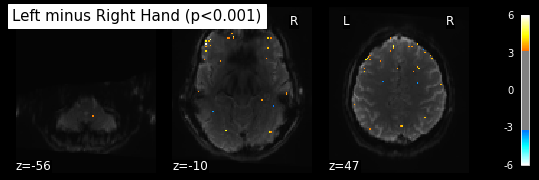

In [56]:
# Uncorrected

from nistats.thresholding import map_threshold
uncorr_001, threshold = map_threshold(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (p<0.001)')
plt.show()

Taux de fausse découverte (FDR) = 0.05 threshold: 3.863


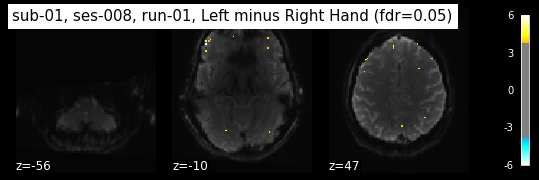

In [57]:
# FDR only

_, threshold = map_threshold(z_map, alpha=.05, height_control='fdr')

print('Taux de fausse découverte (FDR) = 0.05 threshold: %.3f' % threshold)

plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='sub-01, ses-008, run-01, Left minus Right Hand (fdr=0.05)')
plt.show()

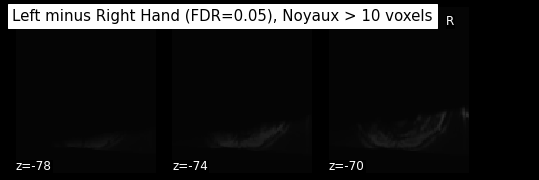

In [58]:
# FDR + clusters

clean_map, threshold = map_threshold(z_map, alpha=.05, height_control='fdr', cluster_threshold=10)

plotting.plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
plt.show()

In [ ]:
# Save interactive plot
view = plotting.view_img(clean_map, threshold=3, title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
view.save_as_html(figures_path + '/LmR_statsmap.html')

In [ ]:
plot_bidsevents(APS_df);

In [2]:
 # Set constants
sub = 'sub-01'
actions = ['B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z']
dpath = '/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/'



seslist= os.listdir(dpath + sub)

allruns_events = []
fmri_img = []
for ses in seslist[:2]:
    runs = [filename[-13] for filename in os.listdir(dpath + '{}/{}/func'.format(sub, ses)) if 'bold.nii.gz' in filename]
    print(runs)
    for run in runs:
        print('computing run {}'.format(run))
        events_fname = dpath + '{}/{}/func/{}_{}_task-shinobi_run-0{}_events.tsv'.format(sub, ses, sub, ses, run)
        filename = dpath + 'derivatives/fmriprep-20.2lts/fmriprep/{}/{}/func/sub-01_{}_task-shinobi_run-{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(sub, ses, ses, run)
        # Obtain list of bk2 files from events
        startevents = pd.read_table(events_fname)
        files = startevents['stim_file'].values.tolist()
        files = [dpath + file for file in files]

        # Retrieve variables from these files
        runvars = retrieve_variables(files)
        events_df = create_runevents(runvars, startevents, actions=actions)
        events_df['trial_type'].unique()

        # Create LvR_df
        lh_df = pd.concat([events_df[events_df['trial_type'] == '1_LEFT'], 
                           events_df[events_df['trial_type'] == '1_RIGHT'],
                           events_df[events_df['trial_type'] == '1_DOWN'],
                           events_df[events_df['trial_type'] == '1_UP'],
                           events_df[events_df['trial_type'] == '4_LEFT'], 
                           events_df[events_df['trial_type'] == '4_RIGHT'],
                           events_df[events_df['trial_type'] == '4_DOWN'],
                           events_df[events_df['trial_type'] == '4_UP'],
                            events_df[events_df['trial_type'] == '5_LEFT'], 
                           events_df[events_df['trial_type'] == '5_RIGHT'],
                           events_df[events_df['trial_type'] == '5_DOWN'],
                           events_df[events_df['trial_type'] == '5_UP']
                          ]).sort_values(by='onset').reset_index(drop=True)
        lh_df['trial_type'] = 'LeftH'

        rh_df = pd.concat([events_df[events_df['trial_type'] == '1_B'], 
                           events_df[events_df['trial_type'] == '1_C'],
                           events_df[events_df['trial_type'] == '4_B'], 
                           events_df[events_df['trial_type'] == '4_C'],
                            events_df[events_df['trial_type'] == '5_B'], 
                           events_df[events_df['trial_type'] == '5_C']
                          ]).sort_values(by='onset').reset_index(drop=True)
        rh_df['trial_type'] = 'RightH'

        LvR_df = pd.concat([lh_df, rh_df]).sort_values(by='onset').reset_index(drop=True)
        
        allruns_events.append(LvR_df)
        
        fmri_img.append(image.concat_imgs(filename))
        
        
        
        
        



['1', '2', '3', '4']
computing run 1
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_001/sub-01_ses-shinobi_001_20200914-150431_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_000.bk2
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_001/sub-01_ses-shinobi_001_20200914-150431_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level4-1_000.bk2
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_001/sub-01_ses-shinobi_001_20200914-150431_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level5-0_000.bk2
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_001/sub-01_ses-shinobi_001_20200914-150431_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_001.bk2
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_001/sub-01_ses-shinobi_001_20200914-150431_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level4-1_001.bk2
Extracting events for /media

['1', '2', '3', '4']
computing run 1
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_002/sub-01_ses-shinobi_002_20200921-151310_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_000.bk2
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_002/sub-01_ses-shinobi_002_20200921-151310_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level4-1_000.bk2
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_002/sub-01_ses-shinobi_002_20200921-151310_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level5-0_000.bk2
/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_002/sub-01_ses-shinobi_002_20200921-151310_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_001.bk2
Extracting events for /media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/sourcedata/sub-01/ses-shinobi_002/sub-01_ses-shinobi_002_20200921-151310_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_000.bk2
Extrac

In [ ]:
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
tr = 1.49
drift_model = 'cosine'
hrf_model='spm'
high_pass=0.1

design_matrices = []
for idx, img in enumerate(fmri_img):
    # Build experimental paradigm
    n_scans = img.shape[-1]
    events = allruns_events[idx]
    # Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    # Build design matrix with the reviously defined parameters
    design_matrix = make_first_level_design_matrix(
            frame_times,
            events,
            hrf_model=hrf_model,
            drift_model=drift_model,
            high_pass=high_pass,
            )

    # put the design matrices in a list
    design_matrices.append(design_matrix)

In [ ]:
plot_design_matrix(design_matrices[0])

In [11]:
from numpy import array

conditions = {
    'LeftH': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'RightH':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

left_minus_right = conditions['LeftH'] - conditions['RightH']

Fitting a GLM


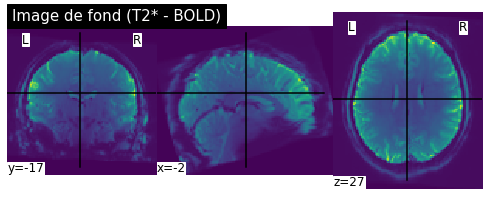

In [51]:
from nilearn.glm.first_level import FirstLevelModel
print('Fitting a GLM')
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)
fmri_glm = fmri_glm.fit(fmri_img, allruns_events)


mean_img = image.mean_img(fmri_img)
plotting.plot_img(mean_img, title='Image de fond (T2* - BOLD)')

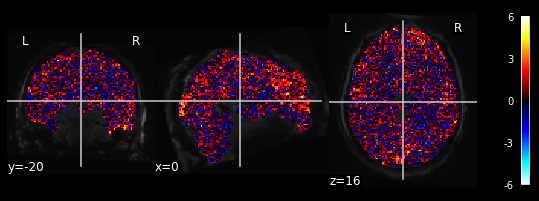

In [52]:
z_map = fmri_glm.compute_contrast(['LeftH-RightH'] * len(fmri_img), 
    output_type='z_score', stat_type='F')

plotting.plot_stat_map(z_map, bg_img=mean_img)

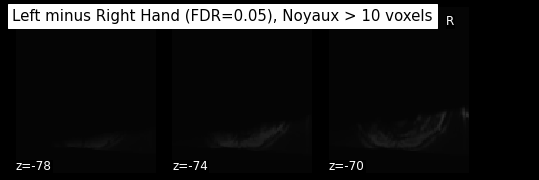

In [55]:
from nistats.thresholding import map_threshold

clean_map, threshold = map_threshold(z_map, alpha=.05, height_control='fdr', cluster_threshold=10)
uncorr_map, threshold = map_threshold(z_map, alpha=.001, height_control='fpr')


plotting.plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
plt.show()

In [18]:
view = plotting.view_img(clean_map, threshold=3, title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
view.save_as_html(figures_path + '/{}_LmR_statsmap_allruns_FDRcluster.html'.format(sub))

view = plotting.view_img(clean_map, threshold=3, title='Left minus Right Hand (p<0.001), uncorr')
view.save_as_html(figures_path + '/{}_LmR_statsmap_allruns_uncorr.html'.format(sub))

(425, 15)
(486, 17)
(485, 17)
(463, 16)
(451, 16)
(434, 15)
(420, 15)
(422, 15)


<AxesSubplot:label='conditions', ylabel='scan number'>

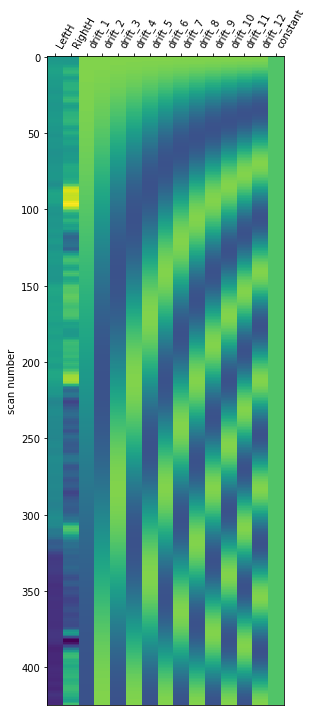

In [34]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])

In [49]:
['LeftH-RightH'] * len(fmri_img)

['LeftH-RightH',
 'LeftH-RightH',
 'LeftH-RightH',
 'LeftH-RightH',
 'LeftH-RightH',
 'LeftH-RightH',
 'LeftH-RightH',
 'LeftH-RightH']